In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.integrate import solve_ivp

Reproduction number R0= 0.9956709956709958
Globally asymptotically stable if beta <=d+nu+mu0. This is False


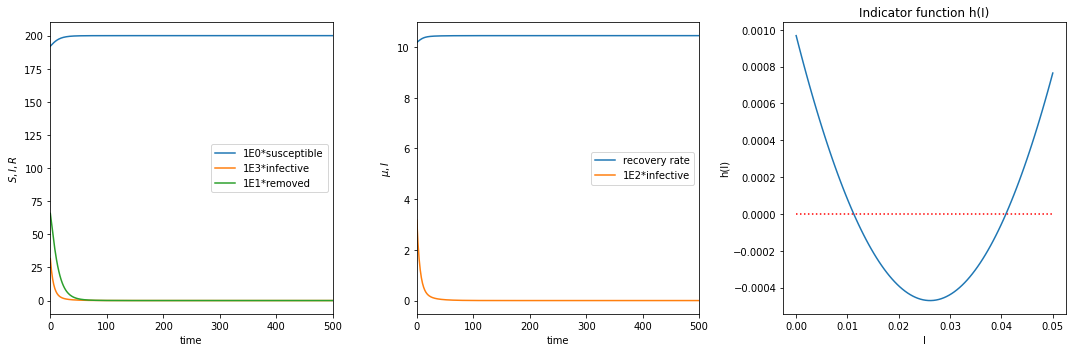

In [4]:
def mu(b, I, mu0, mu1):
    """Recovery rate.
    
    """
    # recovery rate, depends on mu0, mu1, b
    mu = mu0 + (mu1 - mu0) * (b/(I+b))
    return mu

def R0(beta, d, nu, mu1):
    """
    Basic reproduction number.
    """
    return beta / (d + nu + mu1)

def h(I, mu0, mu1, beta, A, d, nu, b):
    """
    Indicator function for bifurcations.
    """
    c0 = b**2 * d * A
    c1 = b * ((mu0-mu1+2*d) * A + (beta-nu)*b*d)
    c2 = (mu1-mu0)*b*nu + 2*b*d*(beta-nu)+d*A
    c3 = d*(beta-nu)
    res = c0 + c1 * I + c2 * I**2 + c3 * I**3
    return res
    

def model(t, y, mu0, mu1, beta, A, d, nu, b):
    """
    SIR model including hospitalization and natural death.
    
    Parameters:
    -----------
    mu0
        Minimum recovery rate
    mu1
        Maximum recovery rate
    beta
        average number of adequate contacts per unit time with infectious individuals
    A
        recruitment rate of susceptibles (e.g. birth rate)
    d
        natural death rate
    nu
        disease induced death rate
    b
        hospital beds per 10,000 persons
    """
    S,I,R = y[:]
    m = mu(b, I, mu0, mu1)
    
    #dSdt = -S # add the correct model here
    #dIdt = 0
    #dRdt = 0
    
    dSdt = A - (d * S) - ((beta * S * I) / (S + I + R))
    dIdt = - ((d + nu) * I) - (m * I) + ((beta * S * I) / (S + I + R))
    dRdt = (m * I) - (d * R)
    
    return [dSdt, dIdt, dRdt]

# parameters
random_state = 12345
t_0 = 0
t_end = 1000
NT = t_end-t_0
# if these error tolerances are set too high, the solution will be qualitatively (!) wrong
rtol=1e-8
atol=1e-8

# SIR model parameters
beta=11.5
A=20
d=0.1
nu=1
b=0.022 # try to set this to 0.01, 0.020, ..., 0.022, ..., 0.03
mu0 = 10   # minimum recovery rate
mu1 = 10.45  # maximum recovery rate

# information
print("Reproduction number R0=", R0(beta, d, nu, mu1))
print('Globally asymptotically stable if beta <=d+nu+mu0. This is', beta <= d+nu+mu0)

# simulation
rng = np.random.default_rng(random_state)

SIM0 = rng.uniform(low=(190, 0, 1), high=(199,0.1,8), size=(3,))
#SIM0 = [195.3,0.052,4.4]
time = np.linspace(t_0,t_end,NT)
sol = solve_ivp(model, t_span=[time[0],time[-1]], y0=SIM0, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b), method='LSODA', rtol=rtol, atol=atol)

fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(sol.t, sol.y[0]-0*sol.y[0][0], label='1E0*susceptible');
ax[0].plot(sol.t, 1e3*sol.y[1]-0*sol.y[1][0], label='1E3*infective');
ax[0].plot(sol.t, 1e1*sol.y[2]-0*sol.y[2][0], label='1E1*removed');
ax[0].set_xlim([0, 500])
ax[0].legend();
ax[0].set_xlabel("time")
ax[0].set_ylabel(r"$S,I,R$")

ax[1].plot(sol.t, mu(b, sol.y[1], mu0, mu1), label='recovery rate')
ax[1].plot(sol.t, 1e2*sol.y[1], label='1E2*infective');
ax[1].set_xlim([0, 500])
ax[1].legend();
ax[1].set_xlabel("time")
ax[1].set_ylabel(r"$\mu,I$")

I_h = np.linspace(-0.,0.05,100)
ax[2].plot(I_h, h(I_h, mu0, mu1, beta, A, d, nu, b));
ax[2].plot(I_h, 0*I_h, 'r:')
#ax[2].set_ylim([-0.1,0.05])
ax[2].set_title("Indicator function h(I)")
ax[2].set_xlabel("I")
ax[2].set_ylabel("h(I)")
fig.tight_layout()

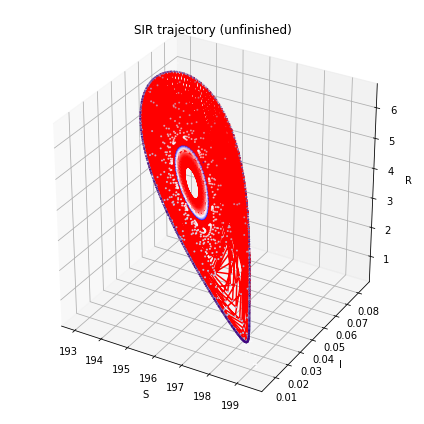

In [24]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111,projection="3d")
time = np.linspace(t_0,15000,NT)

cmap = ["BuPu", "Purples", "bwr"][1]

SIM0 = [195.3, 0.052, 4.4] # what happens with this initial condition when b=0.022? -- it progresses VERY slowly. Needs t_end to be super large.
sol = solve_ivp(model, t_span=[time[0],time[-1]], y0=SIM0, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b), method='DOP853', rtol=rtol, atol=atol)
ax.plot(sol.y[0], sol.y[1], sol.y[2], 'r-');
ax.scatter(sol.y[0], sol.y[1], sol.y[2], s=1, c=time, cmap='bwr');

SIM0 = [195.7, 0.03, 3.92] # what happens with this initial condition when b=0.022?
sol = solve_ivp(model, t_span=[time[0],time[-1]], y0=SIM0, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b), method='DOP853', rtol=rtol, atol=atol)
ax.plot(sol.y[0], sol.y[1], sol.y[2], 'r-');
ax.scatter(sol.y[0], sol.y[1], sol.y[2], s=1, c=time, cmap=cmap);

SIM0 = [193, 0.08, 6.21] # what happens with this initial condition when b=0.022?
sol = solve_ivp(model, t_span=[time[0],time[-1]], y0=SIM0, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b), method='DOP853', rtol=rtol, atol=atol)
ax.scatter(sol.y[0], sol.y[1], sol.y[2], s=1, c=time, cmap=cmap);

ax.set_xlabel("S")
ax.set_ylabel("I")
ax.set_zlabel("R")

ax.set_title("SIR trajectory (unfinished)") 
fig.tight_layout()

In [6]:
b = 0.01 #To manually change b value. 

In [7]:
# We divided three simulations to visualize the trajectories.

In [8]:
#SIM0 = [195.3, 0.052, 4.4]

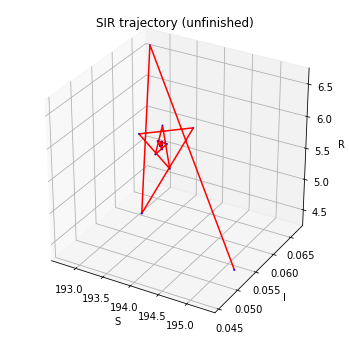

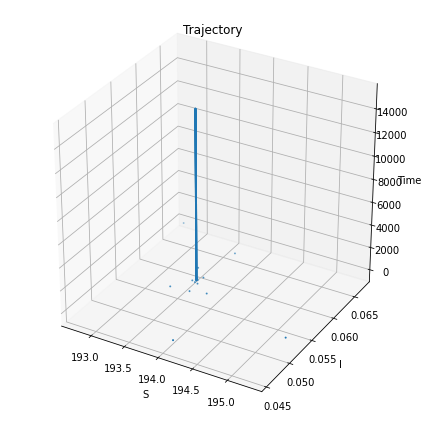

In [9]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111,projection="3d")
time = np.linspace(t_0,15000,NT)
SIM0 = [195.3, 0.052, 4.4] # what happens with this initial condition when b=0.022? -- it progresses VERY slowly. Needs t_end to be super large.
sol = solve_ivp(model, t_span=[time[0],time[-1]], y0=SIM0, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b), method='DOP853', rtol=rtol, atol=atol)
ax.plot(sol.y[0], sol.y[1], sol.y[2], 'r-');
ax.scatter(sol.y[0], sol.y[1], sol.y[2], s=1, c=time, cmap='bwr');
ax.set_xlabel("S")
ax.set_ylabel("I")
ax.set_zlabel("R")
ax.set_title("SIR trajectory (unfinished)") 

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111,projection="3d")
ax.scatter(sol.y[0], sol.y[1], time, s=1, cmap=cmap);
ax.set_xlabel("S")
ax.set_ylabel("I")
ax.set_zlabel("Time")
ax.set_title("Trajectory")
fig.tight_layout()

In [10]:
#2D projection of the trajectory.

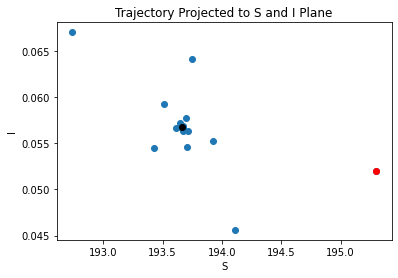

In [11]:
l = len(sol.y[1])
plt.scatter(sol.y[0], sol.y[1])
plt.scatter(sol.y[0][l-1], sol.y[1][l-1], color='black');
plt.scatter(sol.y[0][0], sol.y[1][0], color='red');
plt.xlabel("S")
plt.ylabel("I")
plt.title("Trajectory Projected to S and I Plane")
plt.show()

In [12]:
#SIM0 = [193, 0.08, 6.21]

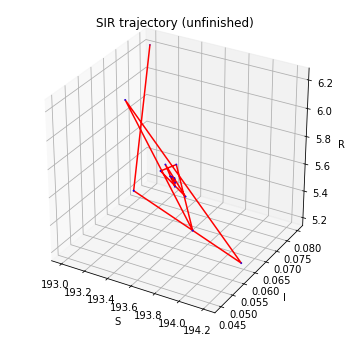

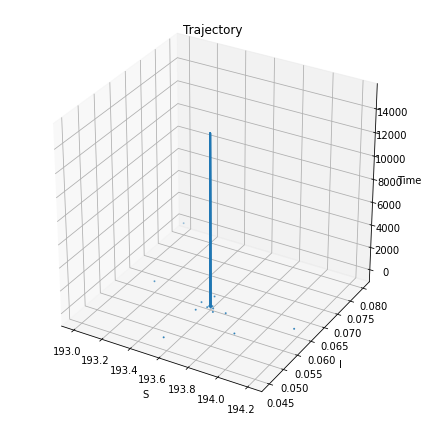

In [13]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111,projection="3d")
time = np.linspace(t_0,15000,NT)
SIM0 = [193, 0.08, 6.21] # what happens with this initial condition when b=0.022? -- it progresses VERY slowly. Needs t_end to be super large.
sol = solve_ivp(model, t_span=[time[0],time[-1]], y0=SIM0, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b), method='DOP853', rtol=rtol, atol=atol)
ax.plot(sol.y[0], sol.y[1], sol.y[2], 'r-');
ax.scatter(sol.y[0], sol.y[1], sol.y[2], s=1, c=time, cmap='bwr');
ax.set_xlabel("S")
ax.set_ylabel("I")
ax.set_zlabel("R")
ax.set_title("SIR trajectory (unfinished)") 

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111,projection="3d")
ax.scatter(sol.y[0], sol.y[1], time, s=1, cmap=cmap);
ax.set_xlabel("S")
ax.set_ylabel("I")
ax.set_zlabel("Time")
ax.set_title("Trajectory")
fig.tight_layout()

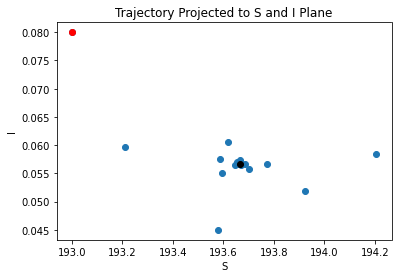

In [14]:
l = len(sol.y[1])
plt.scatter(sol.y[0], sol.y[1])
plt.scatter(sol.y[0][l-1], sol.y[1][l-1], color='black');
plt.scatter(sol.y[0][0], sol.y[1][0], color='red');
plt.xlabel("S")
plt.ylabel("I")
plt.title("Trajectory Projected to S and I Plane")
plt.show()

In [15]:
#SIM0 = [195.7, 0.03, 3.92]

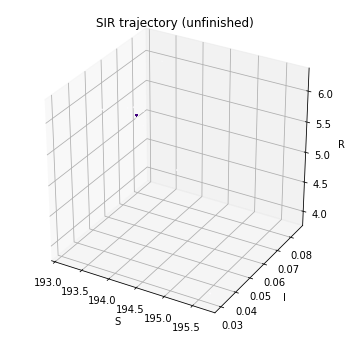

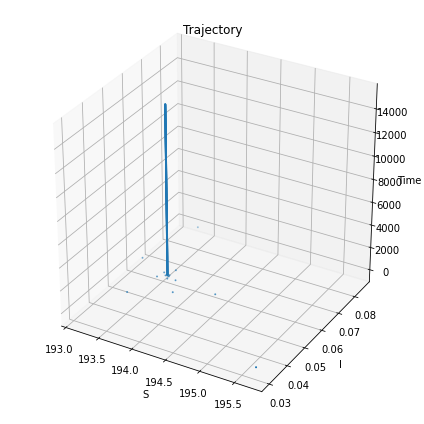

In [16]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111,projection="3d")
time = np.linspace(t_0,15000,NT)
SIM0 = [195.7, 0.03, 3.92] # what happens with this initial condition when b=0.022?
sol = solve_ivp(model, t_span=[time[0],time[-1]], y0=SIM0, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b), method='DOP853', rtol=rtol, atol=atol)
ax.scatter(sol.y[0], sol.y[1], sol.y[2], s=1, c=time, cmap=cmap);
ax.set_xlabel("S")
ax.set_ylabel("I")
ax.set_zlabel("R")
ax.set_title("SIR trajectory (unfinished)") 

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111,projection="3d")
ax.scatter(sol.y[0], sol.y[1], time, s=1, cmap=cmap);
ax.set_xlabel("S")
ax.set_ylabel("I")
ax.set_zlabel("Time")
ax.set_title("Trajectory")
fig.tight_layout()

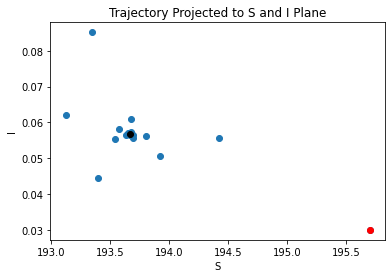

In [17]:
l = len(sol.y[1])
plt.scatter(sol.y[0], sol.y[1])
plt.scatter(sol.y[0][l-1], sol.y[1][l-1], color='black');
plt.scatter(sol.y[0][0], sol.y[1][0], color='red');
plt.xlabel("S")
plt.ylabel("I")
plt.title("Trajectory Projected to S and I Plane")
plt.show()

In [18]:
b = 0.022

In [19]:
#To visualize Hopf Bifurcation: 

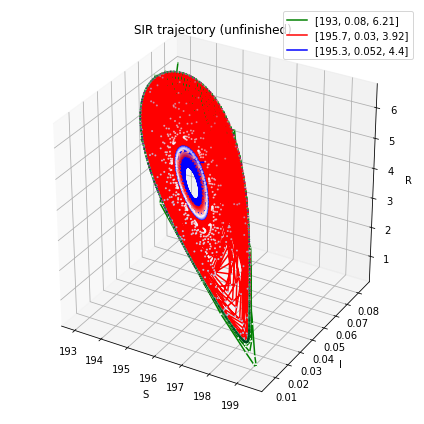

In [20]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111,projection="3d")
SIM0 = [193, 0.08, 6.21] # what happens with this initial condition when b=0.022? -- it progresses VERY slowly. Needs t_end to be super large.
sol = solve_ivp(model, t_span=[time[0],time[-1]], y0=SIM0, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b), method='DOP853', rtol=rtol, atol=atol)
ax.plot(sol.y[0], sol.y[1], sol.y[2], 'g-', label = '[193, 0.08, 6.21]')
ax.scatter(sol.y[0], sol.y[1], sol.y[2], s=1, c=time, cmap='Greens')


SIM0 = [195.7, 0.03, 3.92] # what happens with this initial condition when b=0.022?
sol = solve_ivp(model, t_span=[time[0],time[-1]], y0=SIM0, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b), method='DOP853', rtol=rtol, atol=atol)
ax.plot(sol.y[0], sol.y[1], sol.y[2], 'r-', label = '[195.7, 0.03, 3.92]')
ax.scatter(sol.y[0], sol.y[1], sol.y[2], s=1, c=time, cmap=cmap)

SIM0 = [195.3, 0.052, 4.4] # what happens with this initial condition when b=0.022? -- it progresses VERY slowly. Needs t_end to be super large.
sol = solve_ivp(model, t_span=[time[0],time[-1]], y0=SIM0, t_eval=time, args=(mu0, mu1, beta, A, d, nu, b), method='DOP853', rtol=rtol, atol=atol)
ax.plot(sol.y[0], sol.y[1], sol.y[2], 'b-', label = '[195.3, 0.052, 4.4]')
ax.scatter(sol.y[0], sol.y[1], sol.y[2], s=1, c=time, cmap='bwr')

ax.set_xlabel("S")
ax.set_ylabel("I")
ax.set_zlabel("R")
ax.legend()
ax.set_title("SIR trajectory (unfinished)") 
fig.tight_layout()